In [23]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt
import matplotlib as mpl
from pylab import rcParams
from scipy import integrate

cache = {}
res_folder = 'C:\\Users\\alexandr.pankratov\\bashkirtseva\\curve'

In [8]:
def set_matplotlib_for_grouping_plot():
    rcParams['figure.figsize'] = 16,4
    rcParams['legend.fontsize'] = 22
    rcParams['axes.titlesize'] = 20
    rcParams['xtick.labelsize'] = 22
    rcParams['ytick.labelsize'] = 22
    rcParams['grid.color'] = 'black'
    rcParams['axes.grid'] = True

set_matplotlib_for_grouping_plot()
    
def make_tex_label(source_label):
    newlabels = source_label.split('BREAK')
    return '${0}$\n${1}$'.format(
        newlabels[0].replace(' down','\\downarrow').replace(' up','\\uparrow'), 
        newlabels[1].replace(' down','\\downarrow').replace(' up','\\uparrow'))
def postprocess_labels_for_grouping_plot(ax, labels,title=''):
    labels = list(map(make_tex_label,labels))
    ax.set_xticklabels(labels,rotation = 1)
    ax.set_xlabel('')
    ax.set_title(title)
    ax.legend(['Доля от общего\nчисла паттернов'])

In [9]:
def calc_all_stat(df, suffix, du):
    pc = df['points_count'].unique()
    assert 200 in pc or 400 in pc and len(pc)<=2
    df_200 = df[(df['points_count']==200)]
    df_400 = df[(df['points_count']==400)]
    df_200_cos = df[(df['points_count']==200)&(df['pattern_type']=='cos')]
    df_200_rand = df[(df['points_count']==200)&(df['pattern_type']=='rand')]
    df_400_cos = df[(df['points_count']==400)&(df['pattern_type']=='cos')]
    df_400_rand = df[(df['points_count']==400)&(df['pattern_type']=='rand')]
    calc_stat(df_200_cos, suffix+'; cos; x: [0, 40]', du+', $x \in [0, 40]$')
    calc_stat(df_400_cos, suffix+'; cos; x: [0, 80]', du+', $x \in [0, 80]$')
    calc_stat(df_200_rand, suffix+'; rand; x: [0, 40]', du+', $x \in [0, 40]$')
    calc_stat(df_400_rand, suffix+'; rand; x: [0, 80]', du+', $x \in [0, 80]$')
    calc_stat(df_200, suffix+'; cos and rand; x: [0, 40]', du+', $x \in [0, 40]$')
    calc_stat(df_400, suffix+'; cos and rand; x: [0, 80]', du+', $x \in [0, 80]$')

def calc_stat(df, suffix, du):
    if len(df)==0:
        return
    df[suffix] = 'u: '+df['picks_res_u'].astype(str)+' '+df['direction_res_u'] + 'BREAKv: '+ df['picks_res_v'].astype(str)+' '+df['direction_res_v']
    grouped = df.groupby([suffix])[[suffix]].agg('count')
    grouped[suffix] = grouped[suffix]/grouped[suffix].sum()
    axes = grouped.plot(kind='bar', grid = True,label='')
    postprocess_labels_for_grouping_plot(axes,  grouped.index, du)
    plt.savefig(os.path.join(res_folder, suffix.replace(':','')+' pattern_frac.png'))
    print(suffix)
    plt.show()
    

In [10]:
def _draw_heatmap_internal(data,cmap,dx,dt):
    ax = sns.heatmap(data,cmap=cmap)
    ys = np.linspace(0,data.shape[0],9)
    ax.set_yticks(ys)
    y_labels = ['$x$']+[str(i) for i in (ys*dx)[::-1]][1:-1]
    ax.set_yticklabels(y_labels)
    xs = np.linspace(0,data.shape[1],11)
    ax.set_xticks(xs)
    x_labels = [str(i) for i in (xs*dt)][:-1]+['$t$']
    ax.set_xticklabels(x_labels, rotation=1)
    plt.show()

def draw_heatmap(folder,dt,dx,cmap='Spectral',x_min=None,x_max=None):
    if folder not in cache:
        data = np.loadtxt(os.path.join(folder,'process'),dtype=np.float,delimiter=',')
        cache[folder]=data
    else:
        data = cache[folder]
    max_time = data.shape[0]*dt
    if x_min is None:
        x_min = 0
    x_min = int(x_min/dt) 
    if x_max is None:
        x_max = max_time
    x_max = int(x_max/dt)
    _draw_heatmap_internal(data[:,::2][x_min:x_max].T,cmap,dx,dt)
    _draw_heatmap_internal(data[:,1::2][x_min:x_max].T,cmap,dx,dt)

def fourier_coeff(folder, k, dx, var = 'u', tmax=None, dt=None):
    assert tmax is None or tmax is not None and dt is not None  
    if folder not in cache:
        data = np.loadtxt(os.path.join(folder,'process'),dtype=np.float,delimiter=',')
        cache[folder]=data
    else:
        data = cache[folder]
    if tmax is None:
        tmax = data.shape[0]
    else:
        tmax = int(tmax/dt)
    xmax = int(data.shape[1]/2)*dx
    if var == 'u':
        data = data[:tmax,::2]
    else:
        data = data[:tmax,1::2]
    cos = np.cos(np.arange(0,xmax,dx)*2*np.pi*k/xmax)
    return np.apply_along_axis(lambda x: integrate.simps(cos*x,dx=dx),1,data)

def draw_fourier_coeffs(folder, ks, dx, tmax, dt):
    xs = np.arange(0, tmax, dt)
    set_matplotlib_for_grouping_plot()
    for k in ks:
        fr = fourier_coeff(folder, k, 0.2, 'u', tmax, dt)
        ax = plt.plot(np.arange(0,tmax,0.1), fr, label='$C_{{{0}}}$'.format(k),linewidth=3)
    plt.legend(loc='upper right')
    xticks = plt.xticks()[0][1:-1]
    plt.xticks(ticks=xticks, labels=list(xticks[:-1])+['$t$'])
    yticks = plt.yticks()[0][1:]
    plt.yticks(ticks=yticks, labels=[str(i)[:3] for i in (list(yticks[:-1])+['$C$'])])
    plt.show()
    for k in ks:
        fr = fourier_coeff(folder, k, 0.2, 'v', tmax, dt)
        plt.plot(np.arange(0,tmax,0.1), fr, label='$C_{{{0}}}$'.format(k),linewidth=3)
    xticks = plt.xticks()[0][1:-1]
    plt.xticks(ticks=xticks, labels=list(xticks[:-1])+['$t$'])
    yticks = plt.yticks()[0][1:]
    plt.yticks(ticks=yticks, labels=[str(i)[:3] for i in (list(yticks[:-1])+['$C$'])])
    plt.legend(loc='upper right')
    plt.show()

In [20]:
results = []
for dirpath, subdirs, files in os.walk(res_folder):
    for x in subdirs:
        if 'Du' in x:
            results.append(os.path.join(dirpath, x))

627

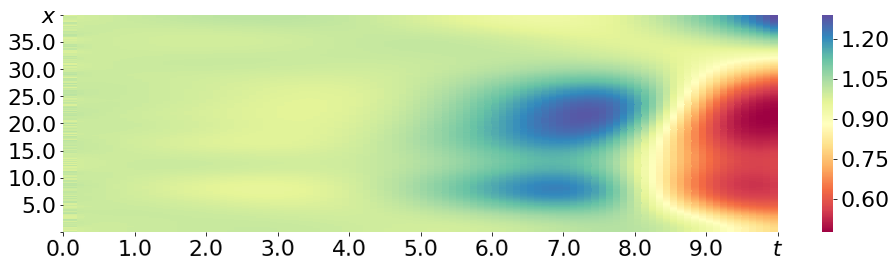

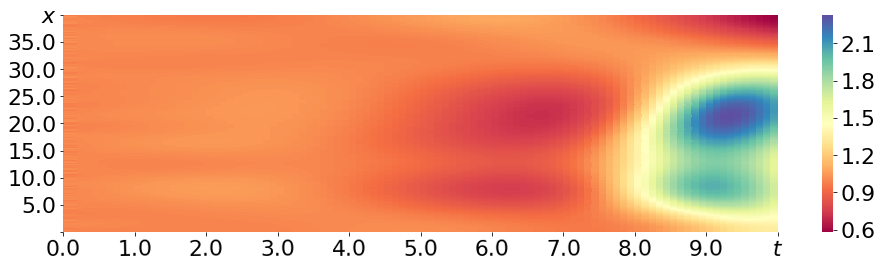

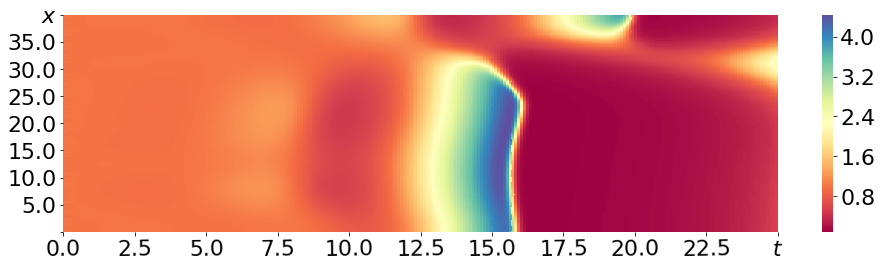

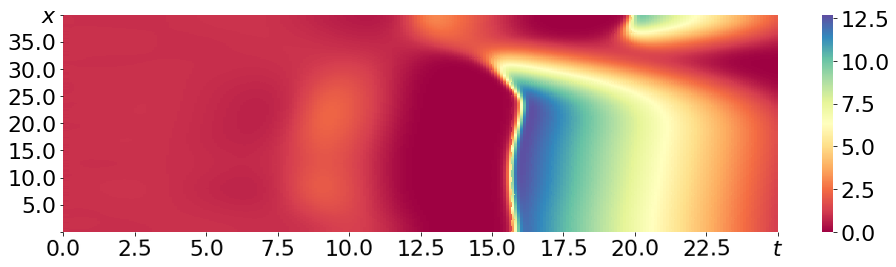

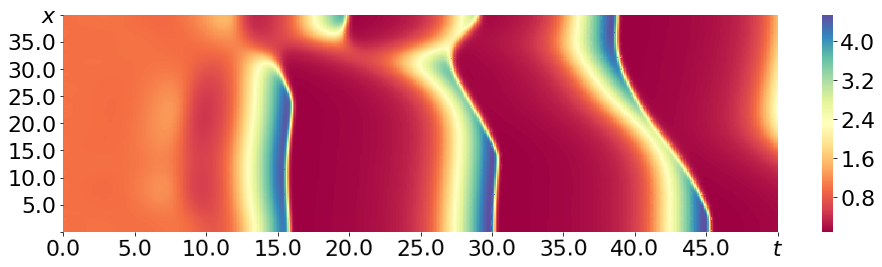

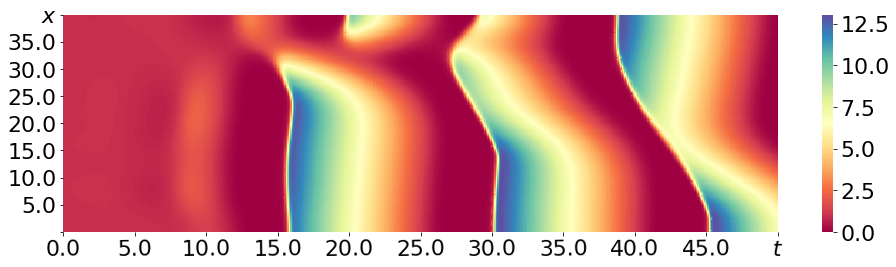

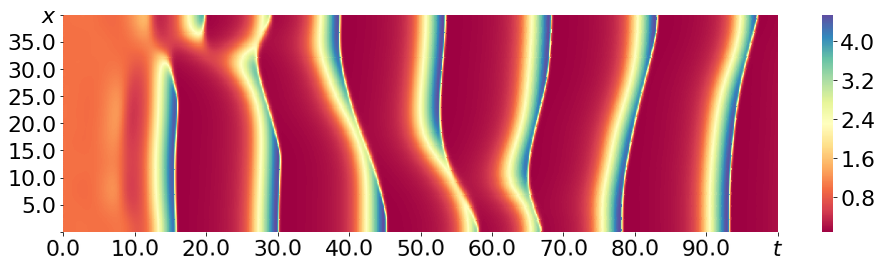

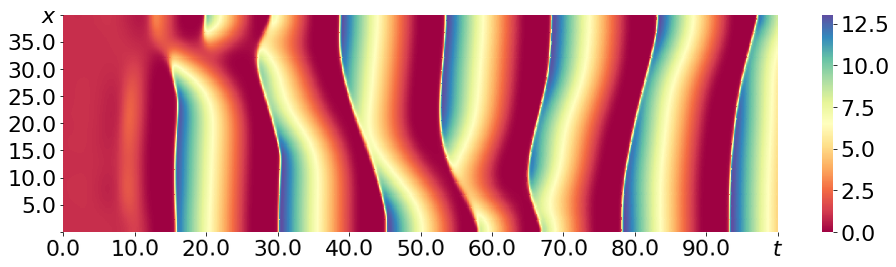

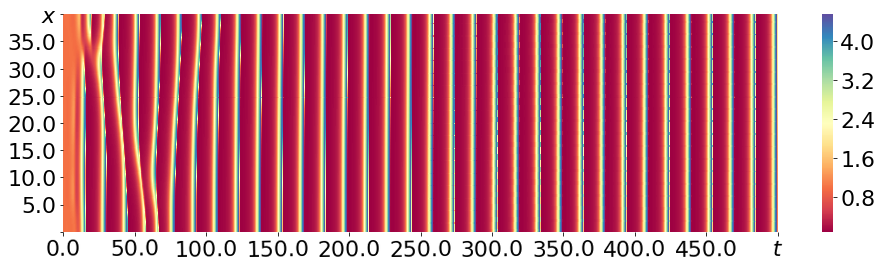

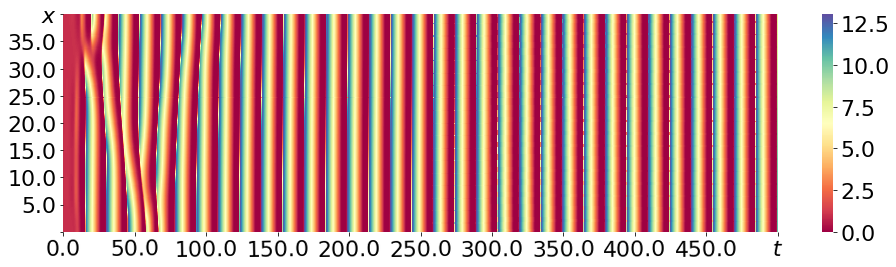

In [11]:
draw_heatmap(path, dt=0.1,dx=0.2,x_max=10)
draw_heatmap(path,dt=0.1,dx=0.2,x_max=25)
draw_heatmap(path, dt=0.1,dx=0.2,x_max=50)
draw_heatmap(path, dt=0.1,dx=0.2,x_max=100)
draw_heatmap(path, dt=0.1,dx=0.2,x_max=500)

Unnamed: 0                                                             0
folder                 C:\Users\alexandr.pankratov\math_newest\2020-0...
pattern_type                                                        rand
amp                                                                  0.5
points_count                                                         200
picks_count                                                          0.5
p                                                                      3
q                                                                      1
Du                                                                     7
Dv                                                                     1
dx                                                                   0.2
picks_res_u                                                            4
direction_res_u                                                     down
picks_res_v                                        

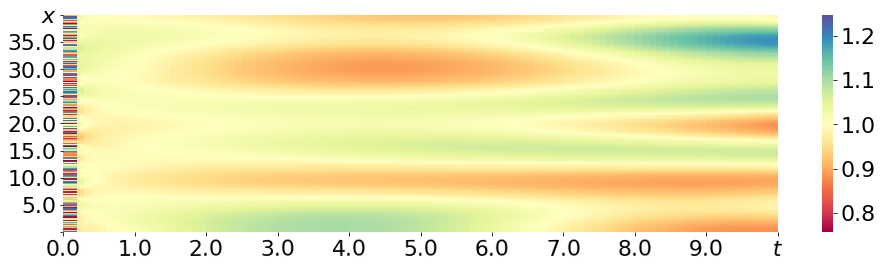

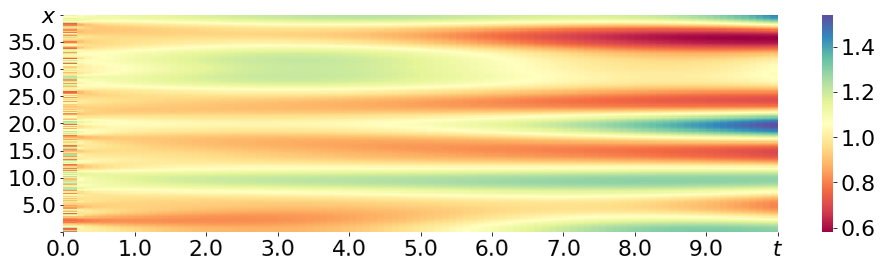

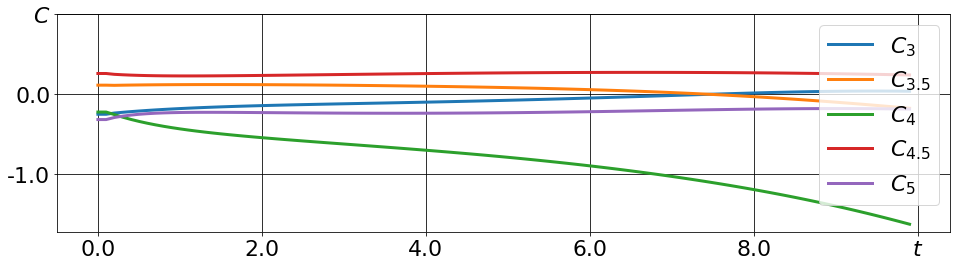

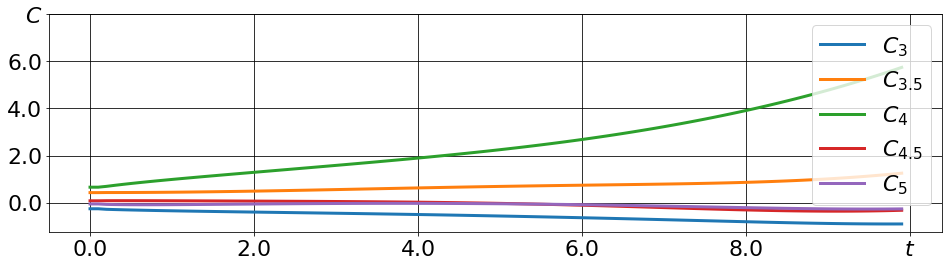

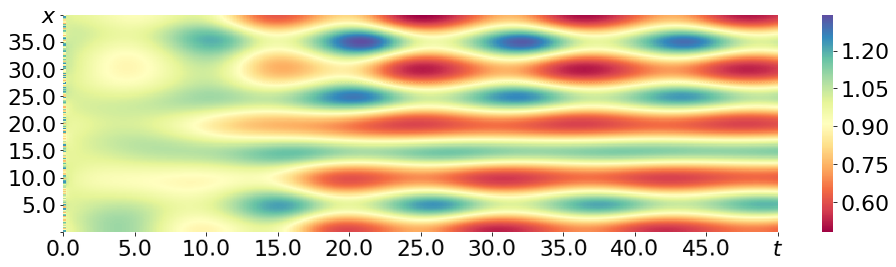

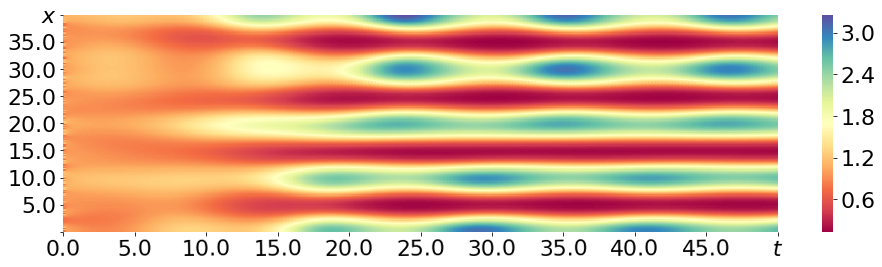

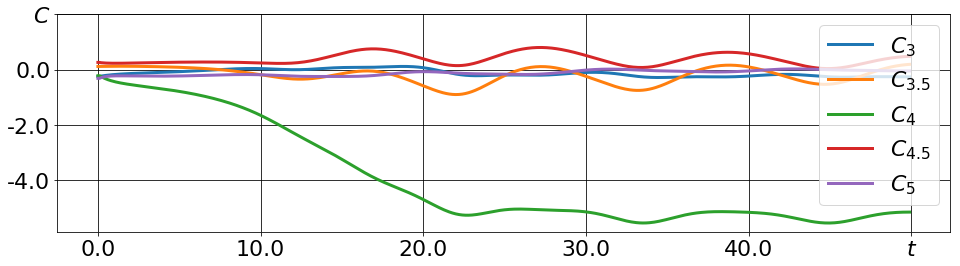

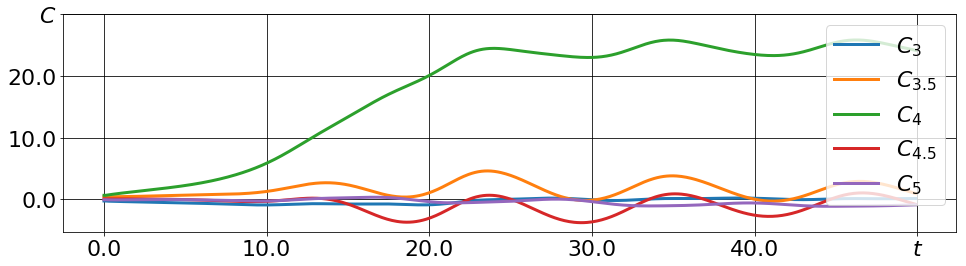

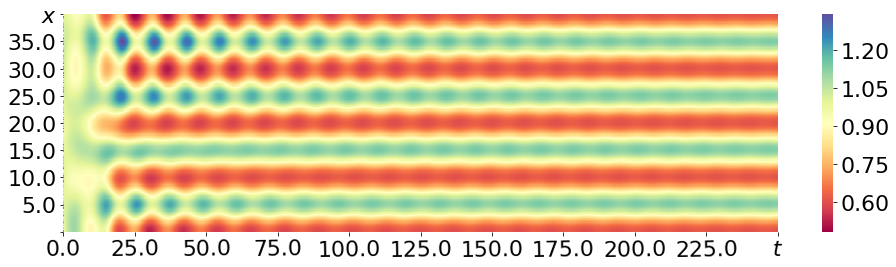

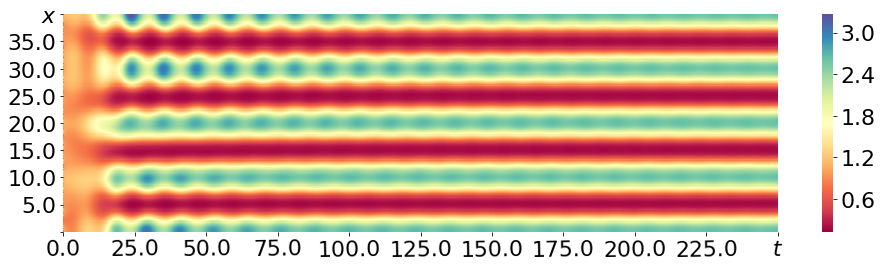

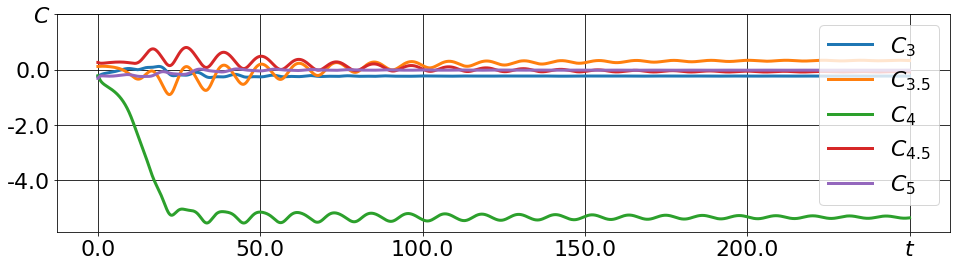

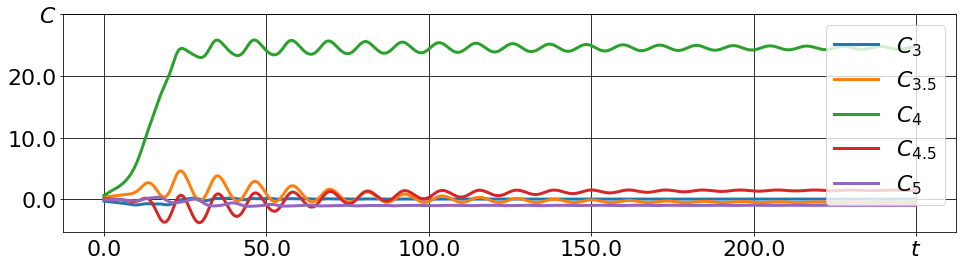

In [110]:
curr_7 = data_7.iloc[0]
print(curr_7)
ks = [3, 3.5, 4,4.5,5]
draw_heatmap(curr_7.folder, dt=0.1,dx=curr_7['dx'],x_max=10)
draw_fourier_coeffs(curr_7.folder,ks,0.2,10,0.1)
draw_heatmap(curr_7.folder,dt=0.1,dx=curr_7['dx'],x_max=50)
draw_fourier_coeffs(curr_7.folder,ks,0.2,50,0.1)

draw_heatmap(curr_7.folder, dt=0.1,dx=curr_7['dx'],x_max=250)
draw_fourier_coeffs(curr_7.folder,ks,0.2,250,0.1)

Unnamed: 0                                                        90
folder             C:\Users\alexandr.pankratov\math_new\2020-02-0...
pattern_type                                                    rand
amp                                                              0.5
points_count                                                     200
picks_count                                                      5.5
p                                                                  3
q                                                                  1
Du                                                                10
Dv                                                                 1
dx                                                               0.2
picks_res_u                                                      4.5
direction_res_u                                                 down
picks_res_v                                                      4.5
direction_res_v                   

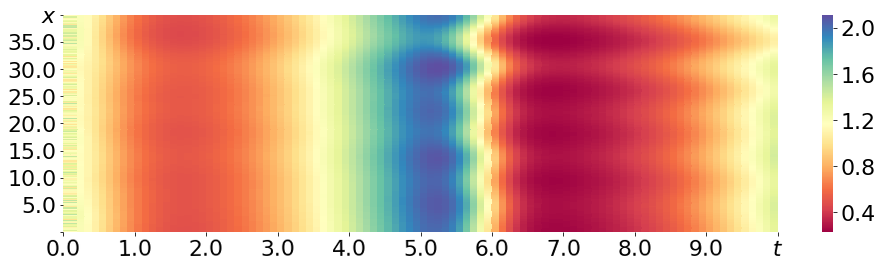

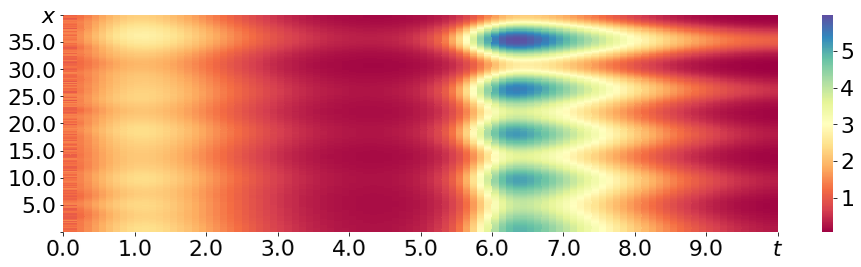

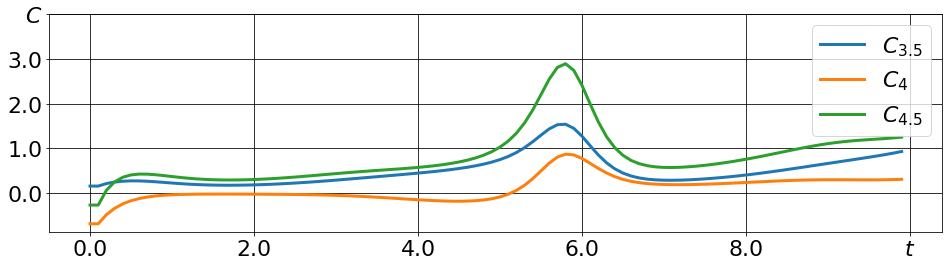

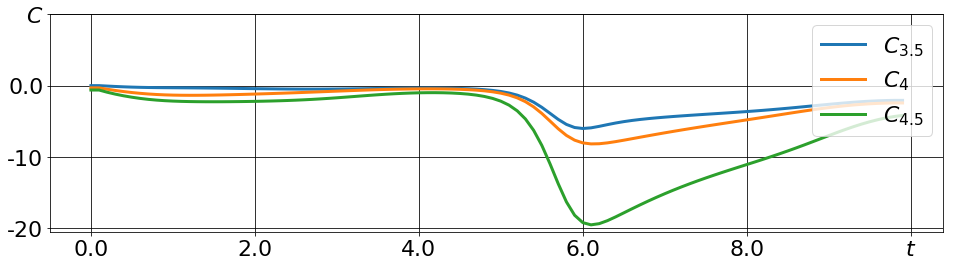

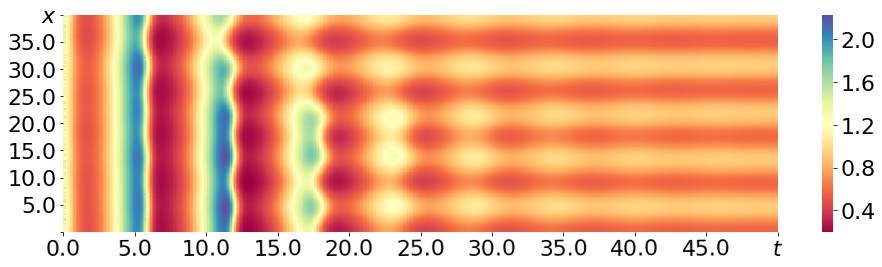

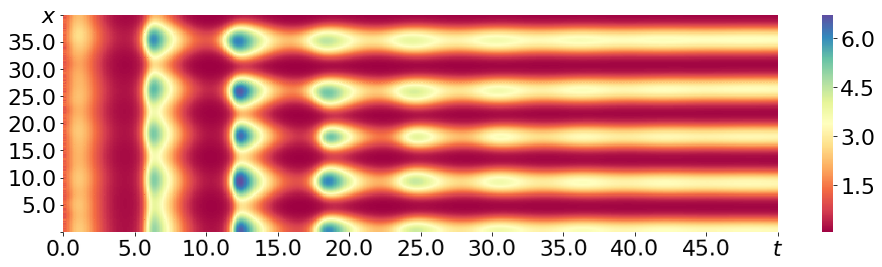

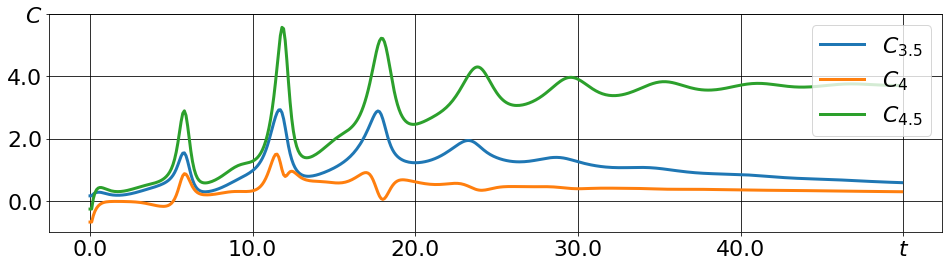

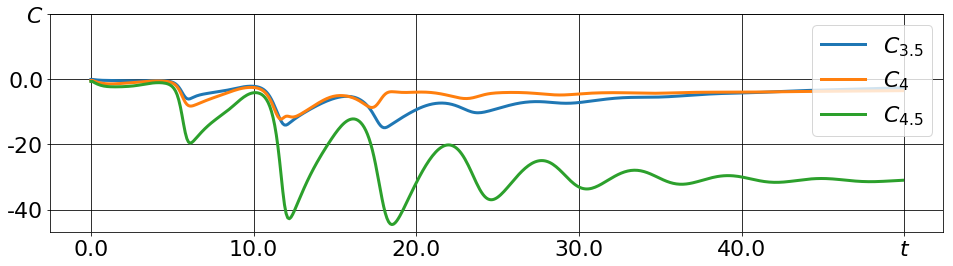

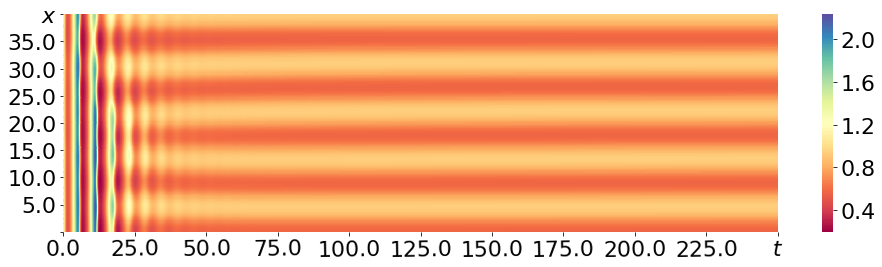

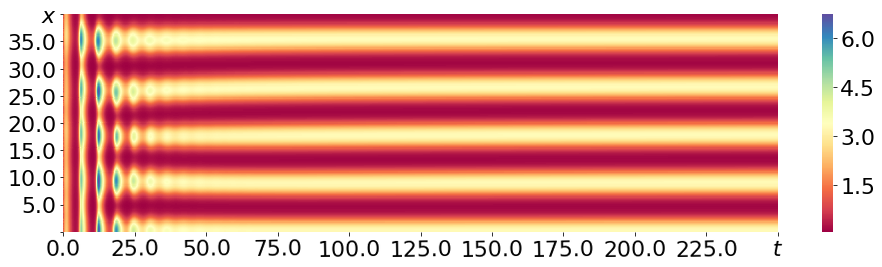

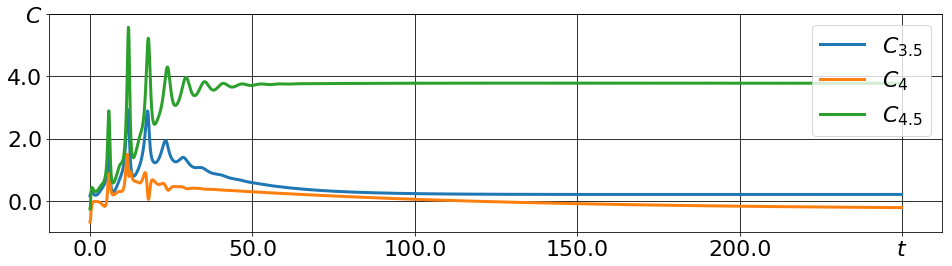

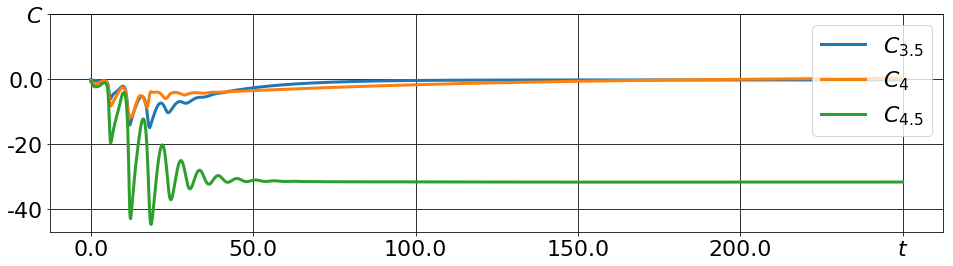

In [122]:
curr_10 = data_10.iloc[90]
print(curr_10)
ks = [3.5,4,4.5]
draw_heatmap(curr_10.folder, dt=0.1,dx=curr_10['dx'],x_max=10)
draw_fourier_coeffs(curr_10.folder,ks,0.2,10,0.1)
draw_heatmap(curr_10.folder,dt=0.1,dx=curr_10['dx'],x_max=50)
draw_fourier_coeffs(curr_10.folder,ks,0.2,50,0.1)
draw_heatmap(curr_10.folder, dt=0.1,dx=curr_10['dx'],x_max=250)
draw_fourier_coeffs(curr_10.folder,ks,0.2,250,0.1)

Unnamed: 0                                                         1
folder             C:\Users\alexandr.pankratov\math\2020-01-15\20...
pattern_type                                                    rand
amp                                                              0.5
points_count                                                     400
picks_count                                                        1
p                                                                  3
q                                                                  1
Du                                                                20
Dv                                                                 1
dx                                                               0.2
picks_res_u                                                        7
direction_res_u                                                   up
picks_res_v                                                        7
direction_res_v                   

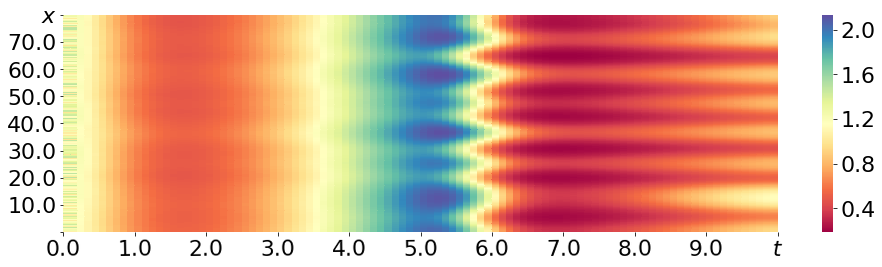

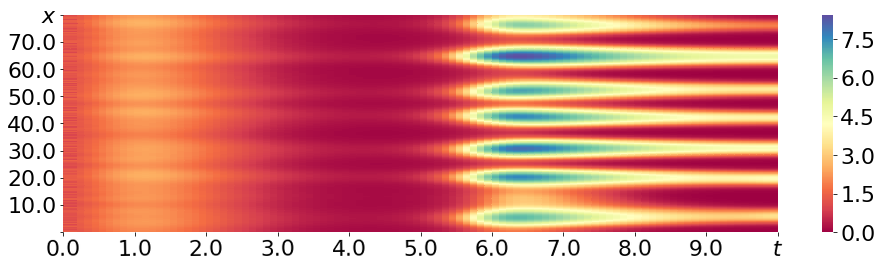

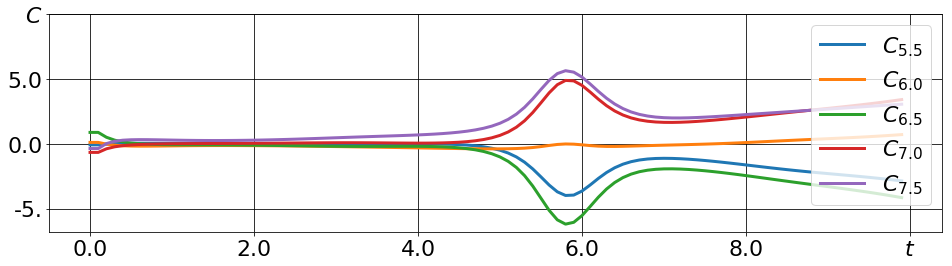

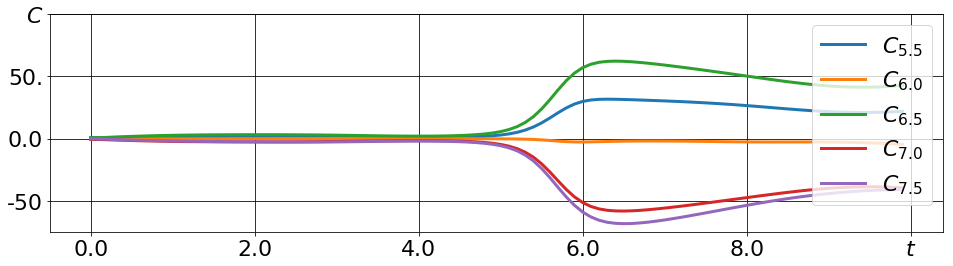

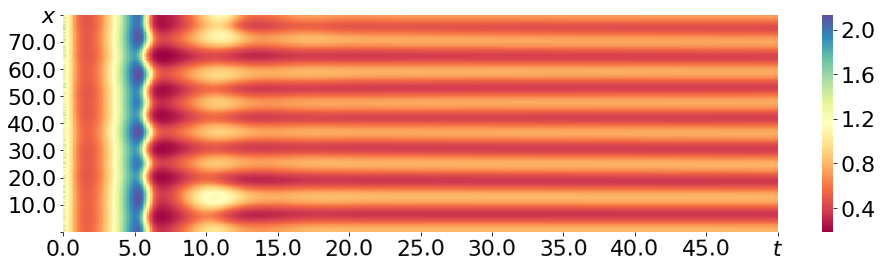

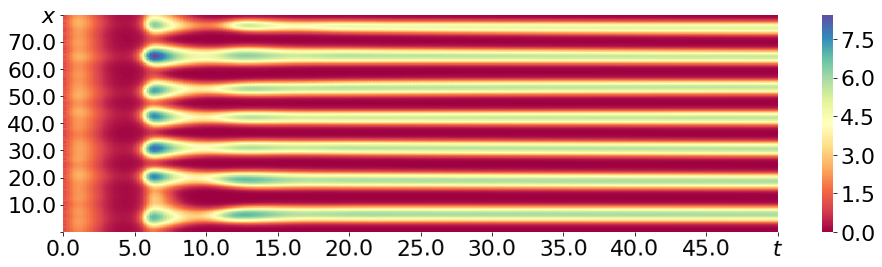

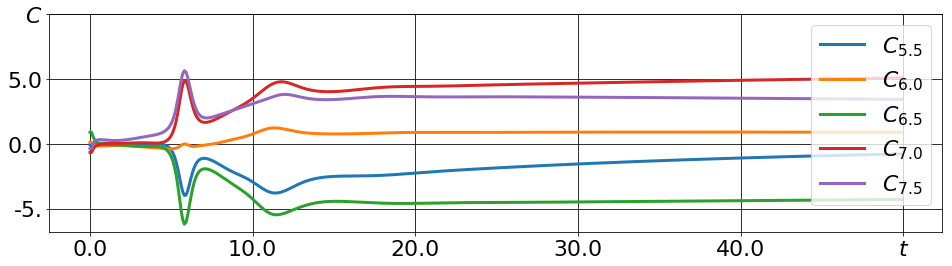

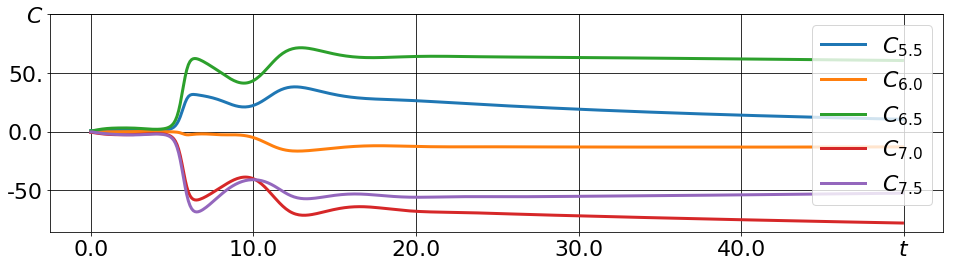

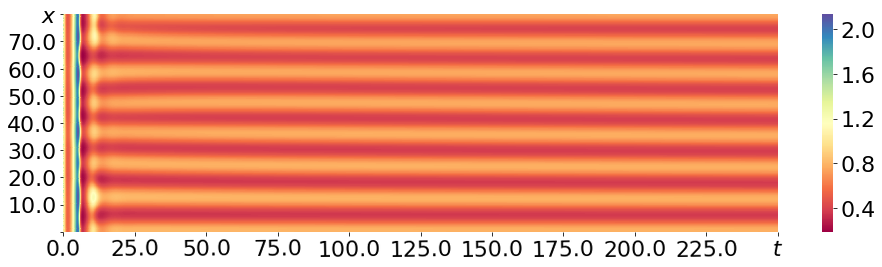

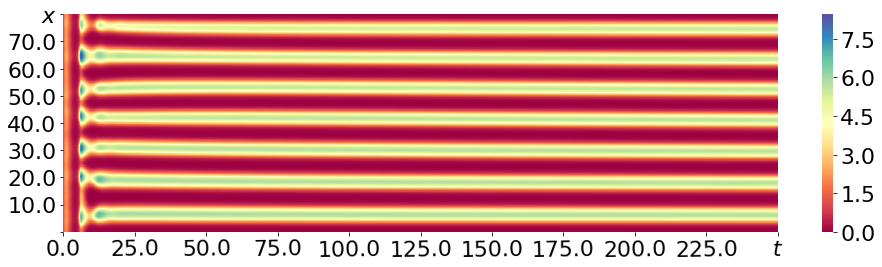

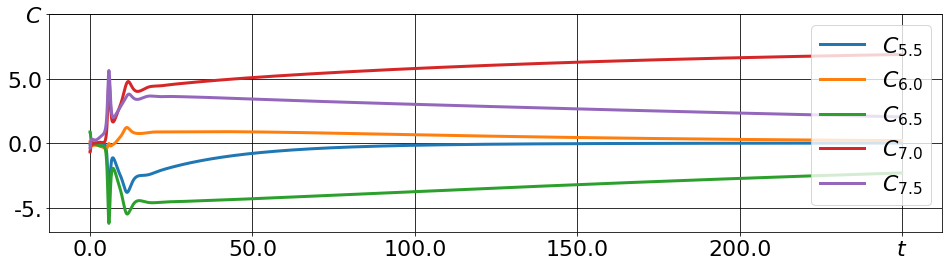

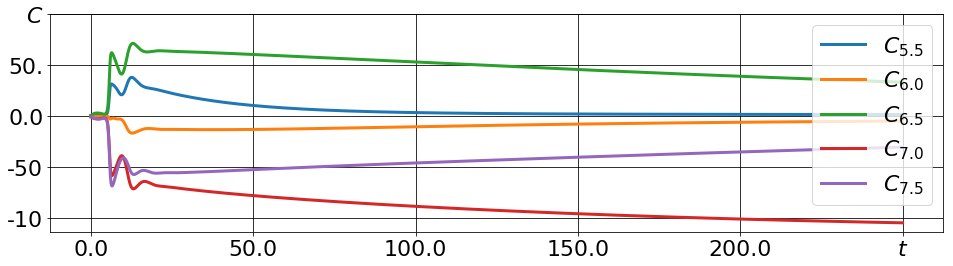

Unnamed: 0                                                         2
folder             C:\Users\alexandr.pankratov\math\2020-01-15\20...
pattern_type                                                    rand
amp                                                              0.5
points_count                                                     400
picks_count                                                      1.5
p                                                                  3
q                                                                  1
Du                                                                20
Dv                                                                 1
dx                                                               0.2
picks_res_u                                                        6
direction_res_u                                                 down
picks_res_v                                                        6
direction_res_v                   

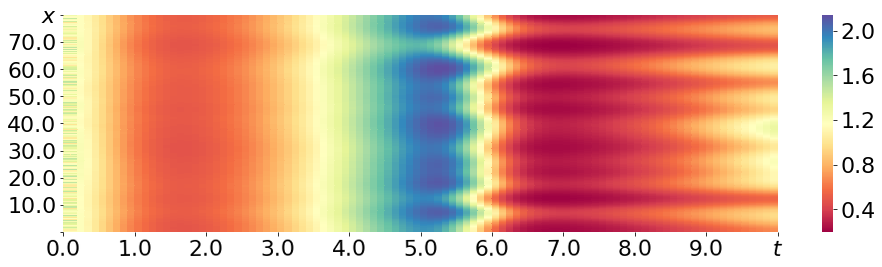

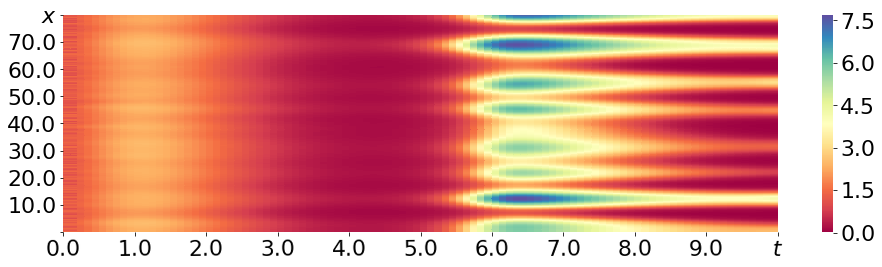

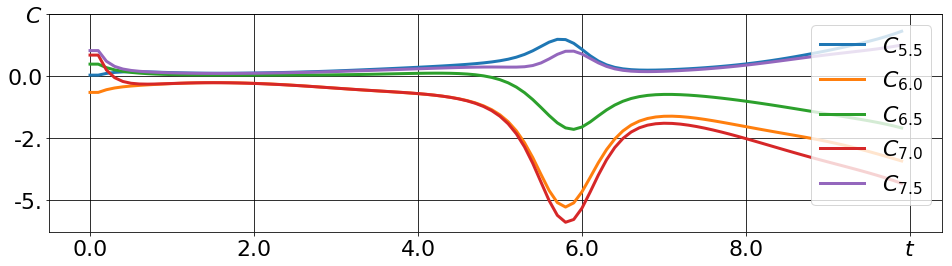

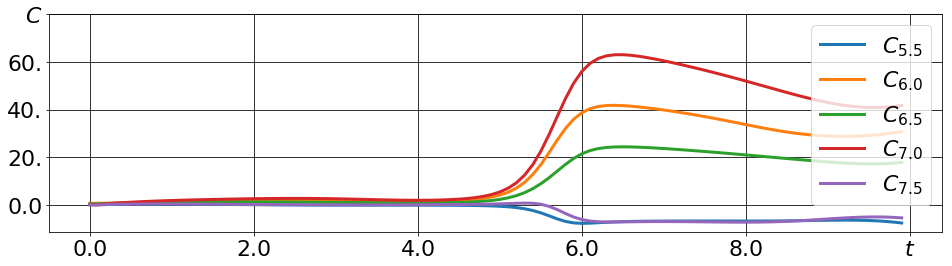

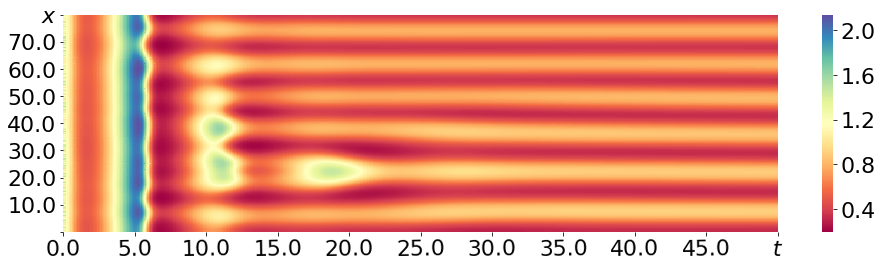

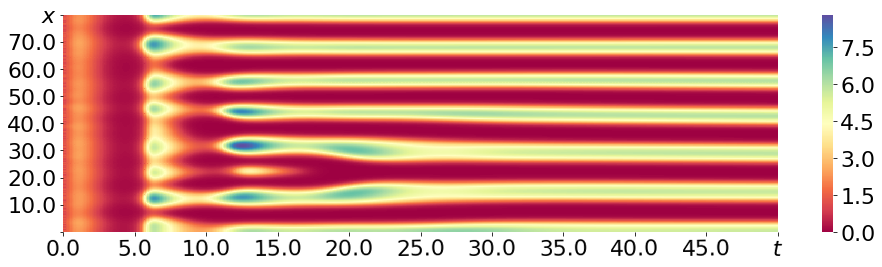

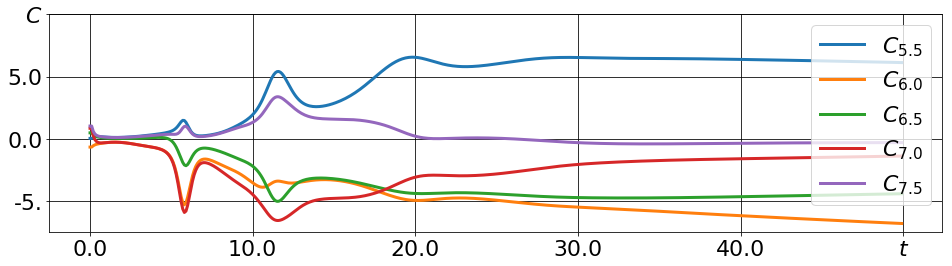

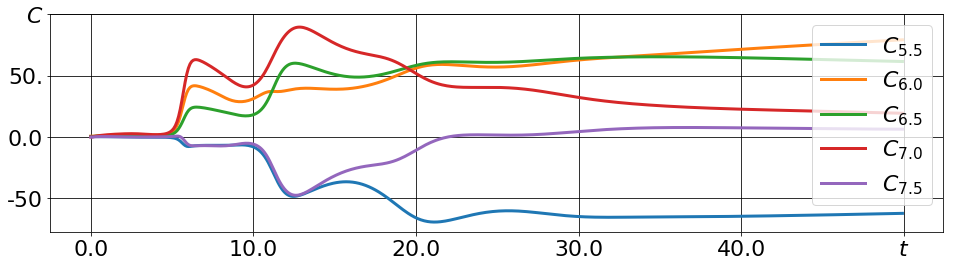

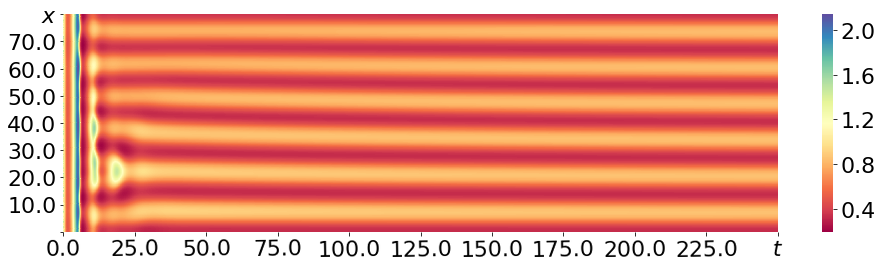

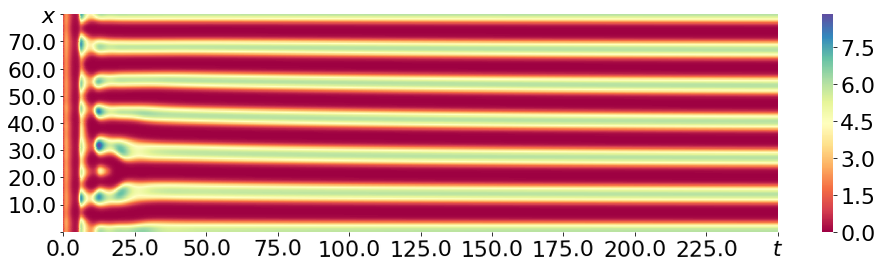

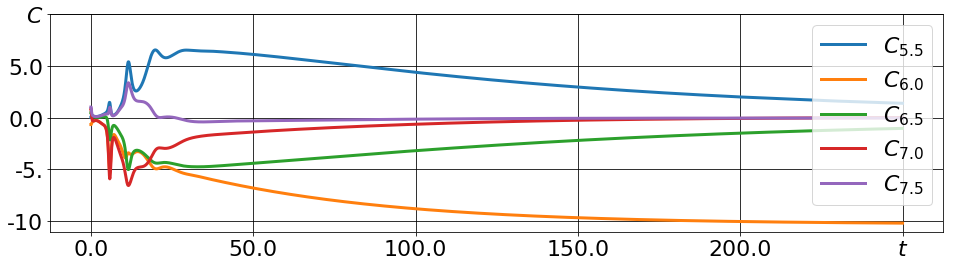

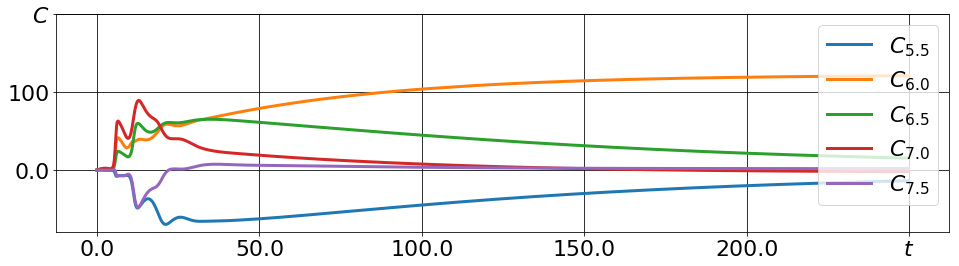

Unnamed: 0                                                         3
folder             C:\Users\alexandr.pankratov\math\2020-01-15\20...
pattern_type                                                    rand
amp                                                              0.5
points_count                                                     400
picks_count                                                        2
p                                                                  3
q                                                                  1
Du                                                                20
Dv                                                                 1
dx                                                               0.2
picks_res_u                                                      6.5
direction_res_u                                                 down
picks_res_v                                                      6.5
direction_res_v                   

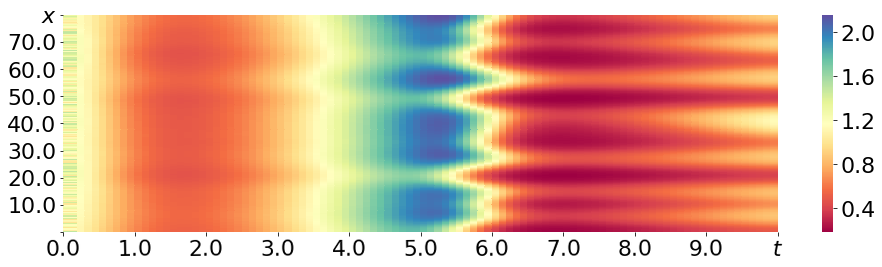

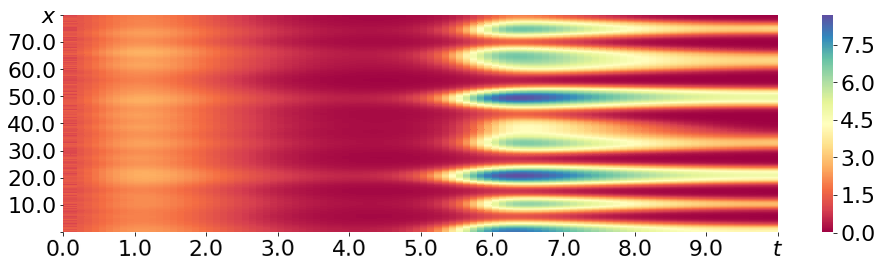

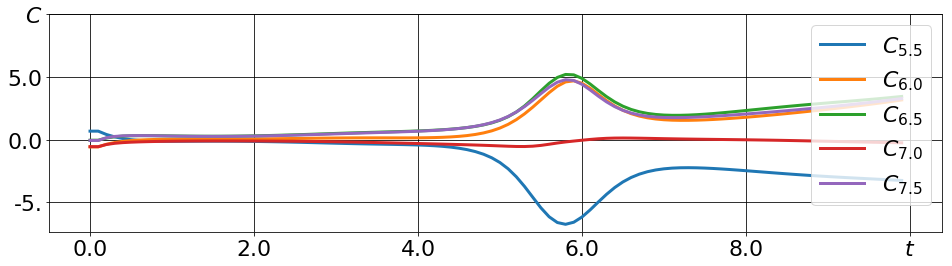

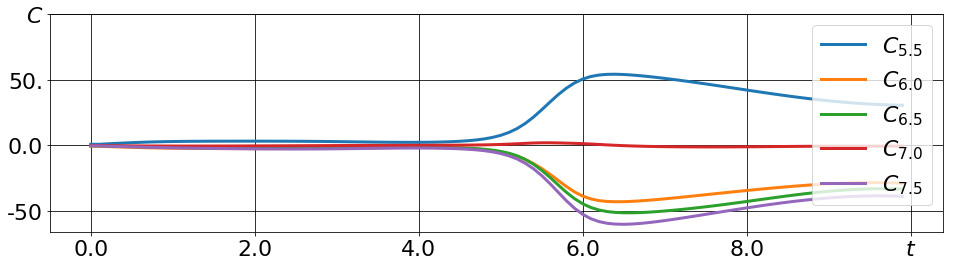

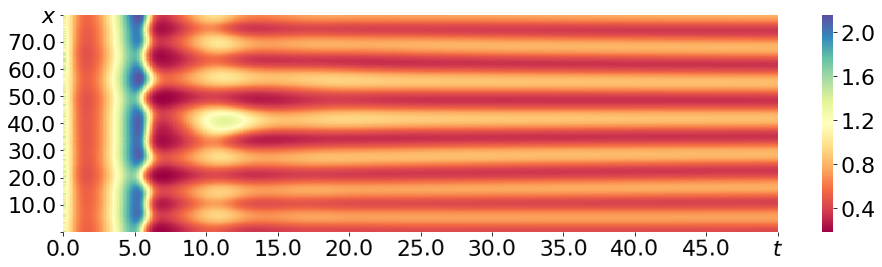

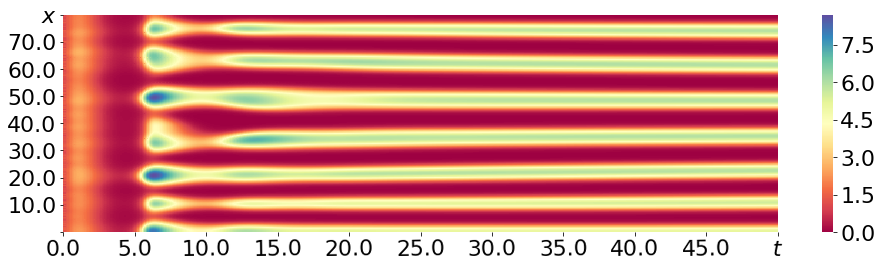

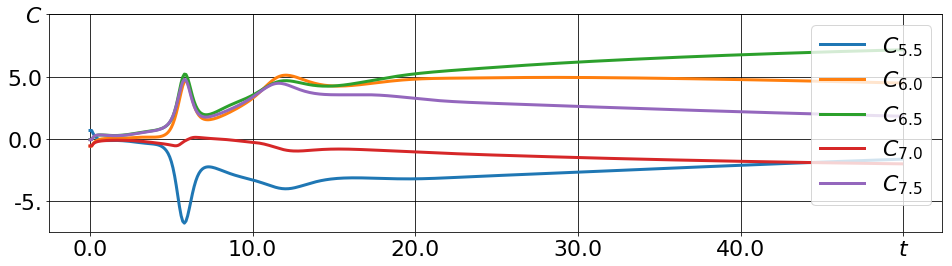

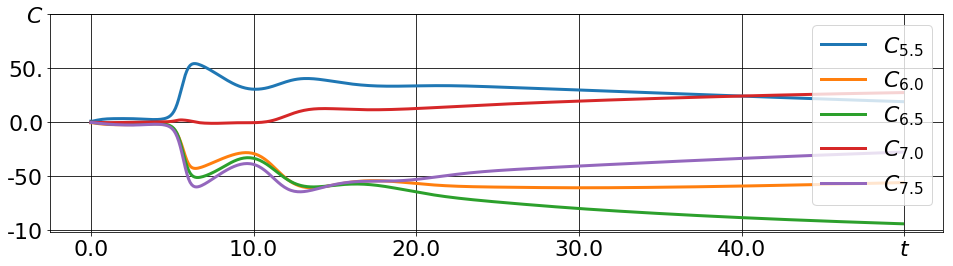

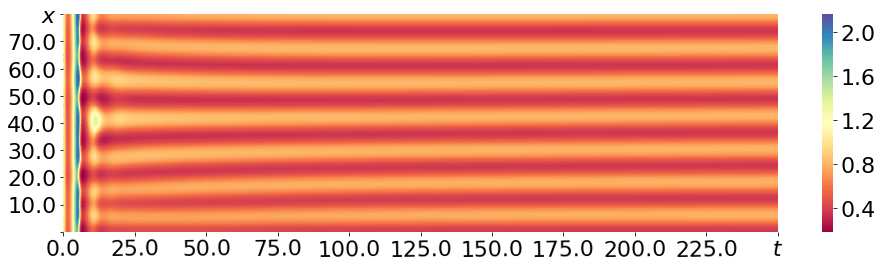

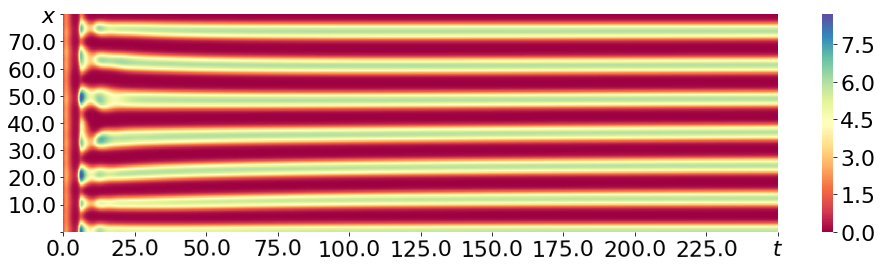

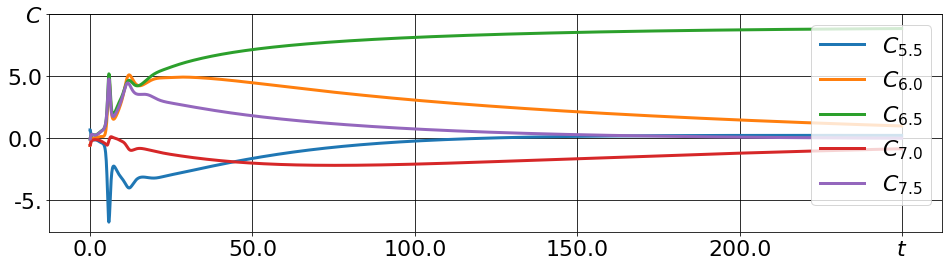

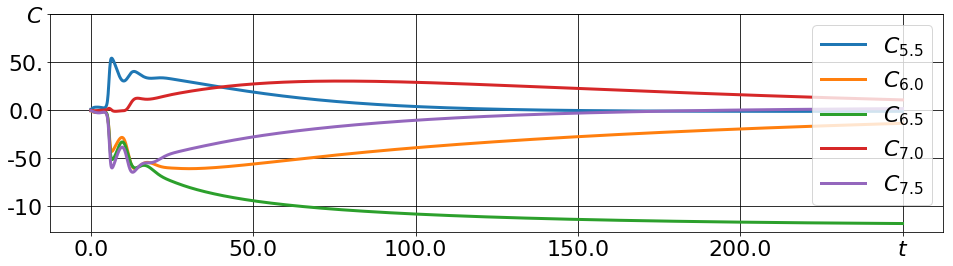

In [123]:
curr_20 = data_20.iloc[1]
print(curr_20)
ks = np.arange(5.5,8,0.5)
draw_heatmap(curr_20.folder, dt=0.1,dx=curr_20['dx'],x_max=10)
draw_fourier_coeffs(curr_20.folder,ks,0.2,10,0.1)
draw_heatmap(curr_20.folder, 0.1,dx=curr_20['dx'],x_max=50)
draw_fourier_coeffs(curr_20.folder,ks,0.2,50,0.1)
draw_heatmap(curr_20.folder, 0.1,dx=curr_20['dx'],x_max=250)
draw_fourier_coeffs(curr_20.folder,ks,0.2,250,0.1)

curr_20 = data_20.iloc[2]
print(curr_20)
ks = np.arange(5.5,8,0.5)
draw_heatmap(curr_20.folder, dt=0.1,dx=curr_20['dx'],x_max=10)
draw_fourier_coeffs(curr_20.folder,ks,0.2,10,0.1)
draw_heatmap(curr_20.folder, 0.1,dx=curr_20['dx'],x_max=50)
draw_fourier_coeffs(curr_20.folder,ks,0.2,50,0.1)
draw_heatmap(curr_20.folder, 0.1,dx=curr_20['dx'],x_max=250)
draw_fourier_coeffs(curr_20.folder,ks,0.2,250,0.1)

curr_20 = data_20.iloc[3]
print(curr_20)
ks = np.arange(5.5,8,0.5)
draw_heatmap(curr_20.folder, dt=0.1,dx=curr_20['dx'],x_max=10)
draw_fourier_coeffs(curr_20.folder,ks,0.2,10,0.1)
draw_heatmap(curr_20.folder, 0.1,dx=curr_20['dx'],x_max=50)
draw_fourier_coeffs(curr_20.folder,ks,0.2,50,0.1)
draw_heatmap(curr_20.folder, 0.1,dx=curr_20['dx'],x_max=250)
draw_fourier_coeffs(curr_20.folder,ks,0.2,250,0.1)

Unnamed: 0                                                             1
folder                 C:\Users\alexandr.pankratov\math_newest\2020-0...
pattern_type                                                        rand
amp                                                                  0.5
points_count                                                         200
picks_count                                                            1
p                                                                      3
q                                                                      1
Du                                                                     7
Dv                                                                     1
dx                                                                   0.2
picks_res_u                                                            4
direction_res_u                                                     down
picks_res_v                                        

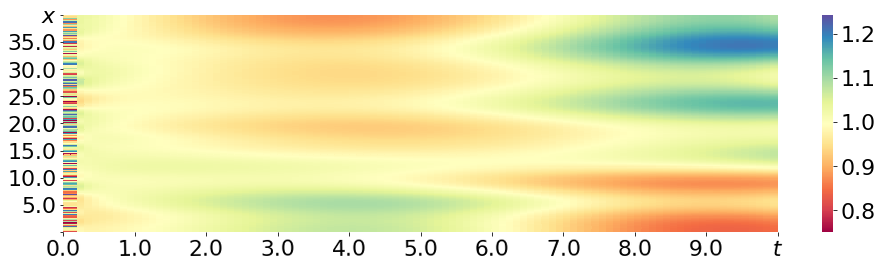

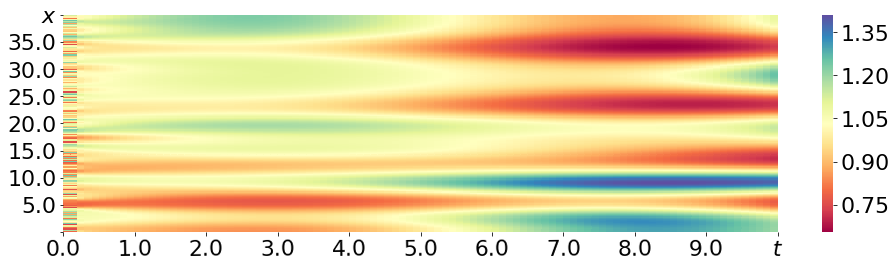

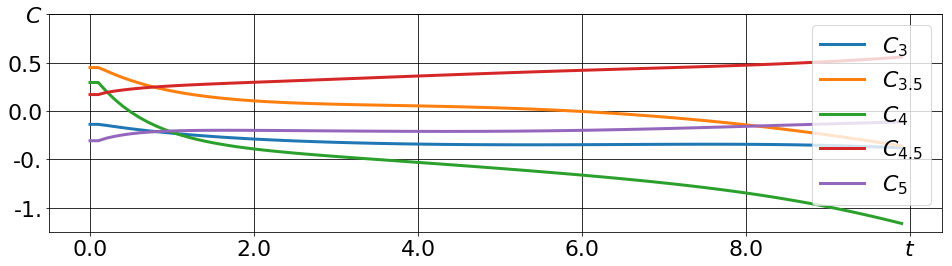

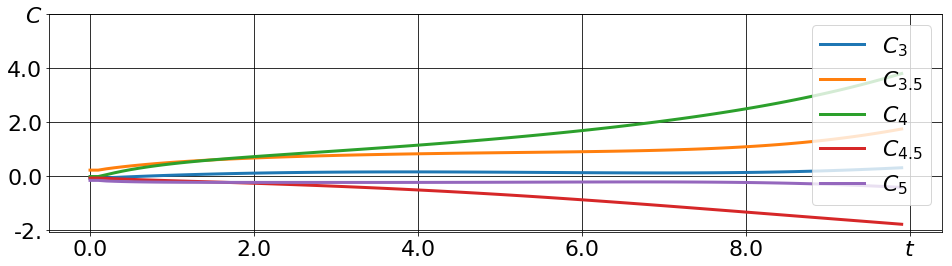

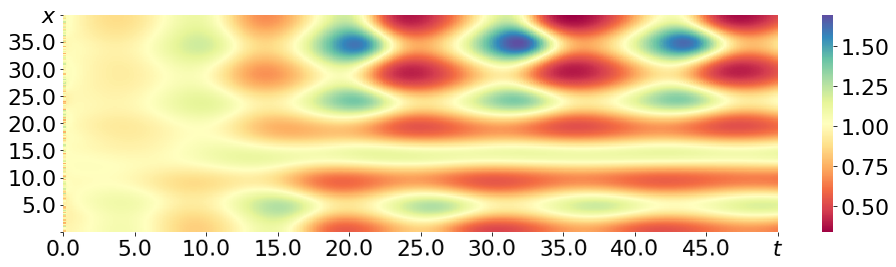

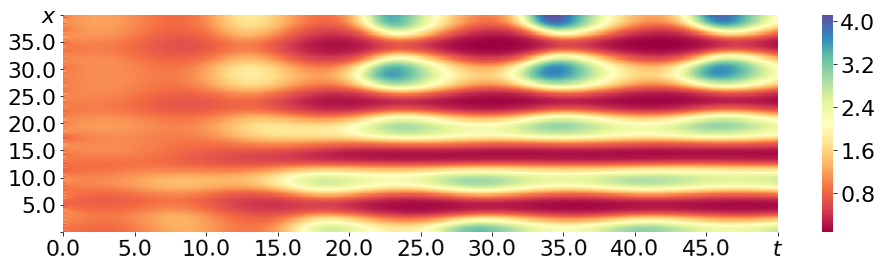

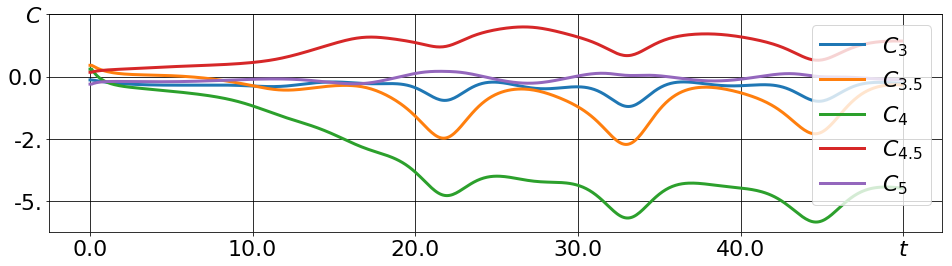

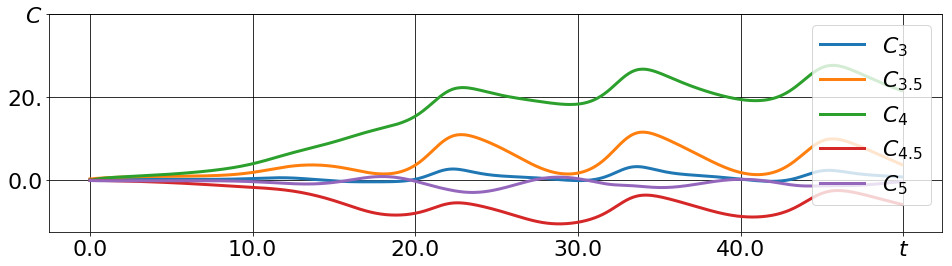

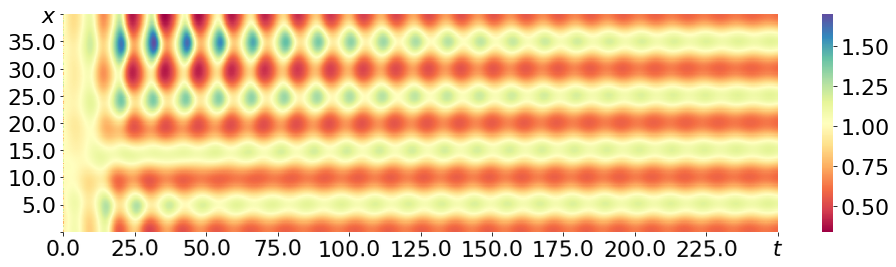

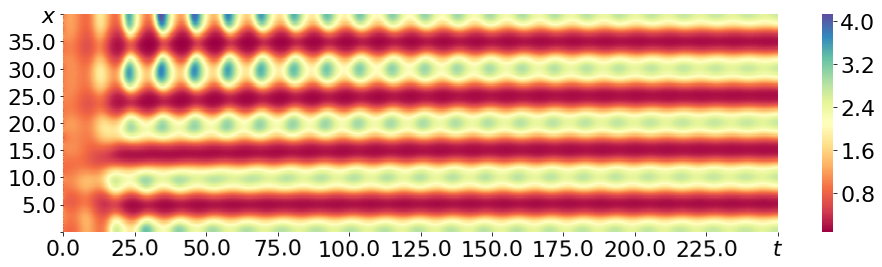

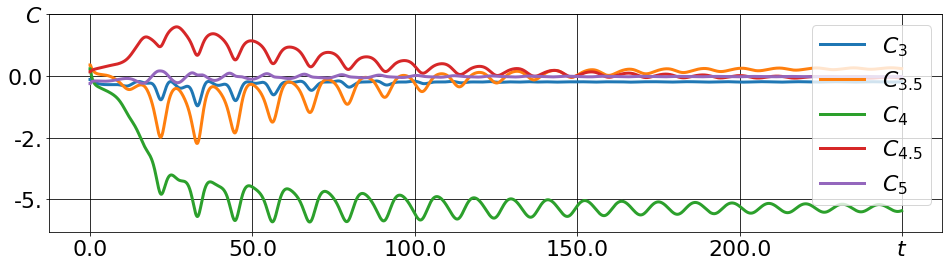

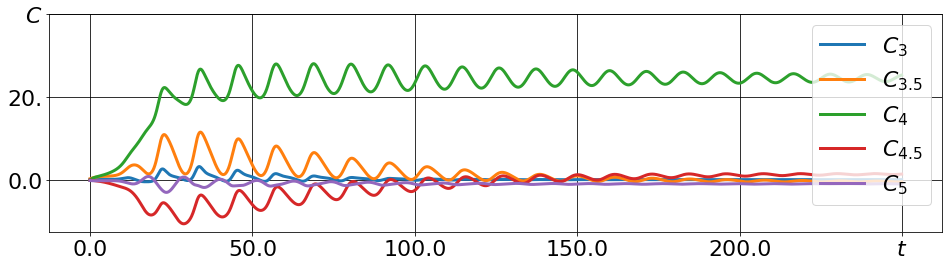

Unnamed: 0                                                             2
folder                 C:\Users\alexandr.pankratov\math_newest\2020-0...
pattern_type                                                        rand
amp                                                                  0.5
points_count                                                         200
picks_count                                                          1.5
p                                                                      3
q                                                                      1
Du                                                                     7
Dv                                                                     1
dx                                                                   0.2
picks_res_u                                                          4.5
direction_res_u                                                     down
picks_res_v                                        

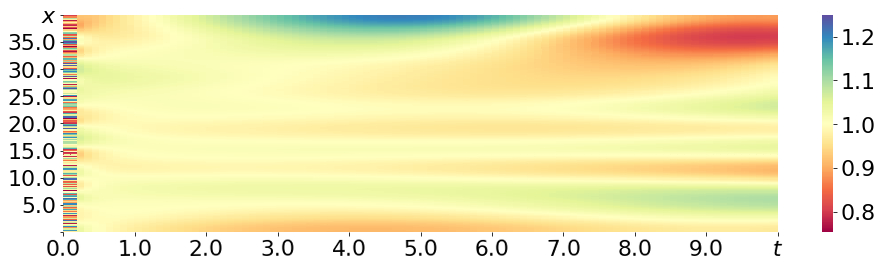

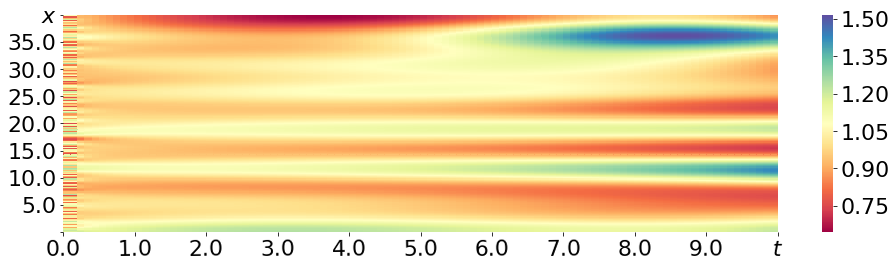

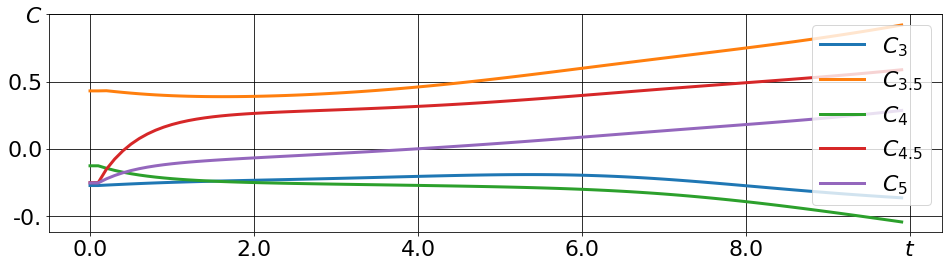

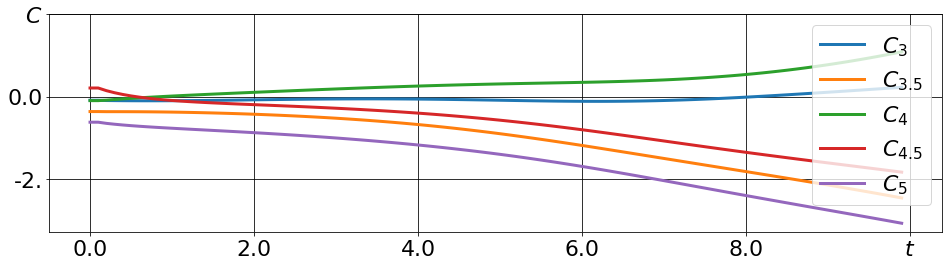

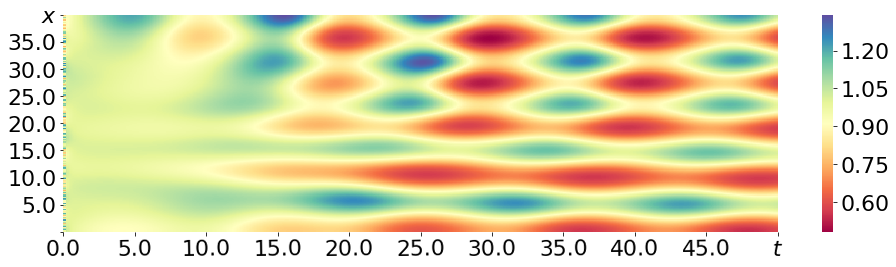

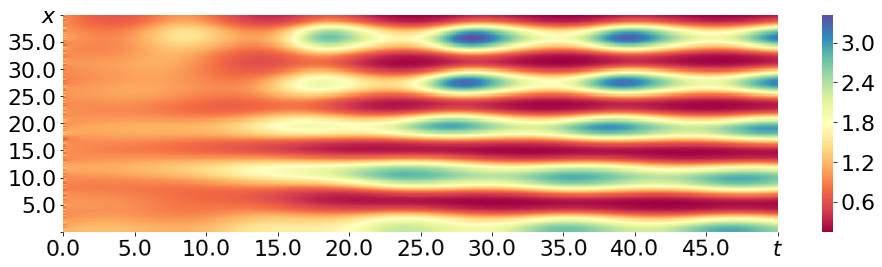

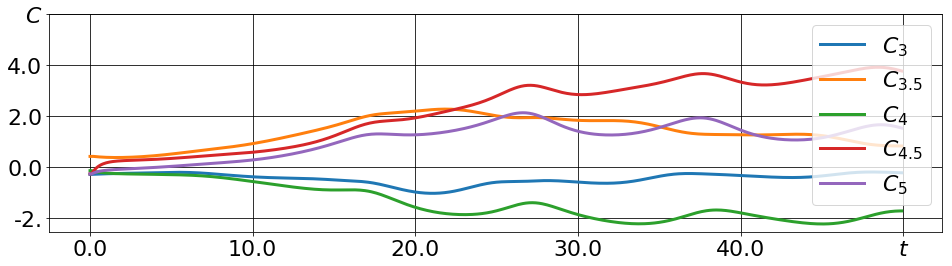

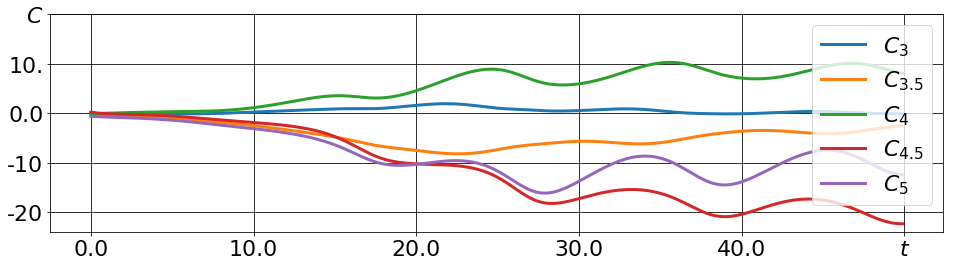

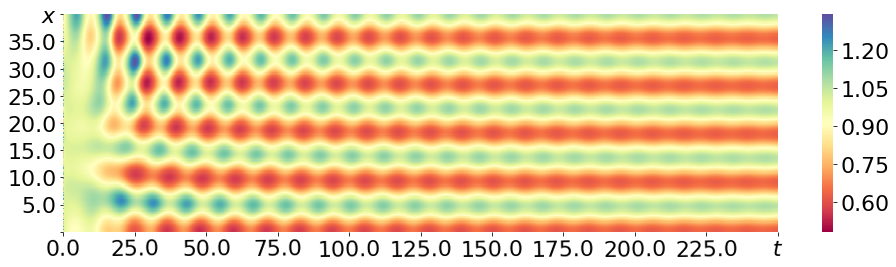

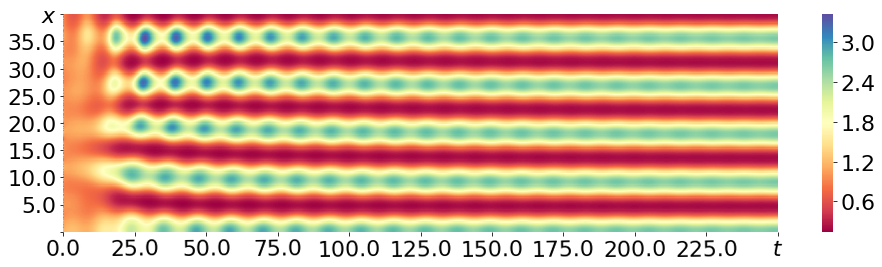

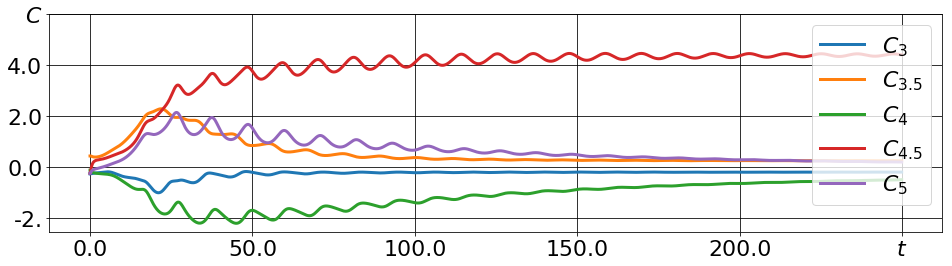

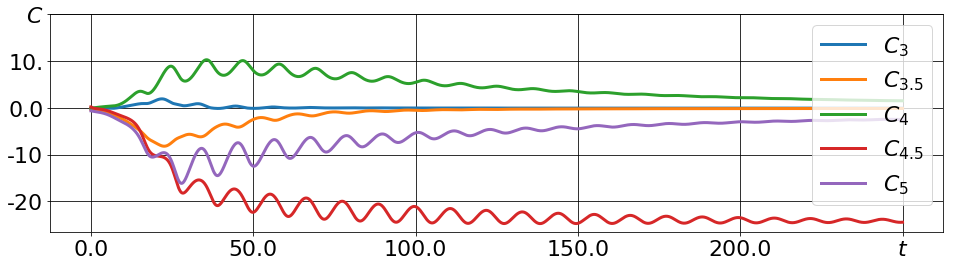

Unnamed: 0                                                             3
folder                 C:\Users\alexandr.pankratov\math_newest\2020-0...
pattern_type                                                        rand
amp                                                                  0.5
points_count                                                         200
picks_count                                                            2
p                                                                      3
q                                                                      1
Du                                                                     7
Dv                                                                     1
dx                                                                   0.2
picks_res_u                                                          4.5
direction_res_u                                                       up
picks_res_v                                        

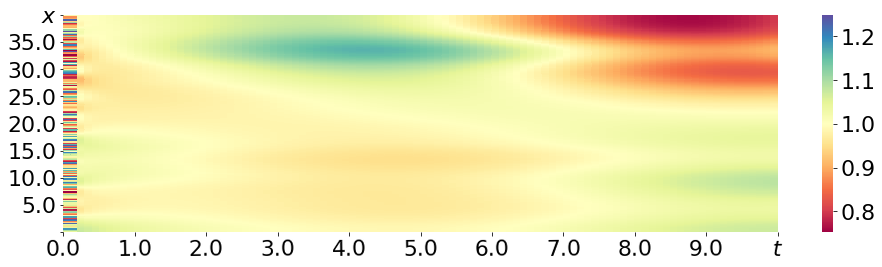

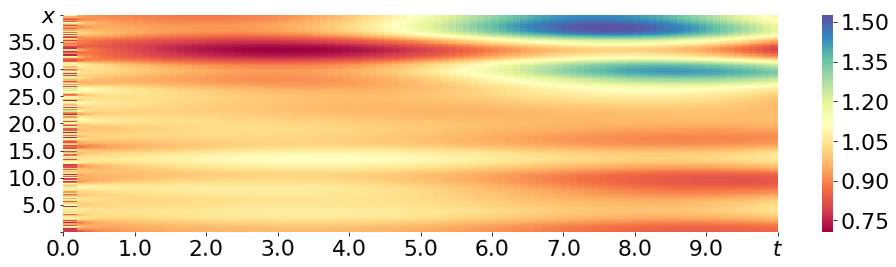

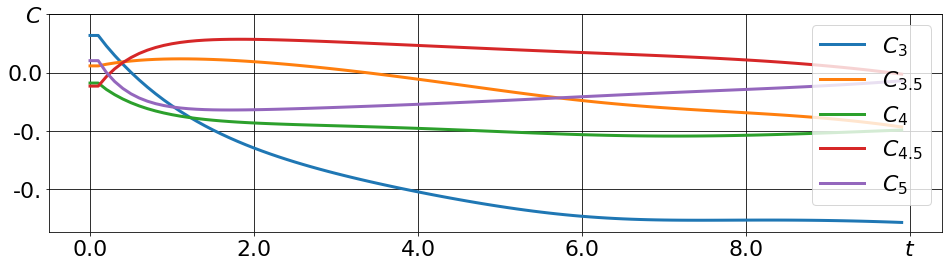

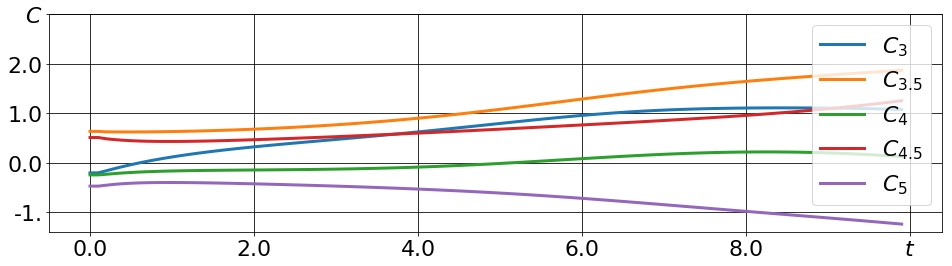

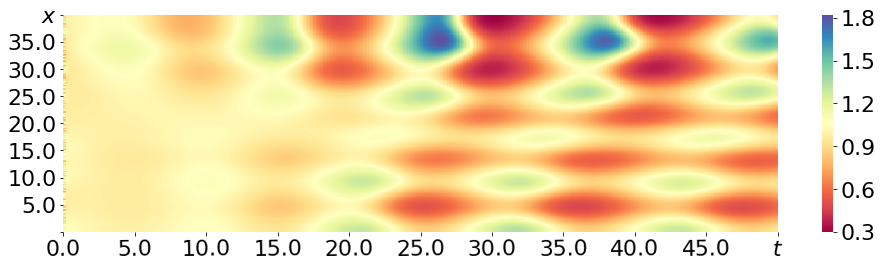

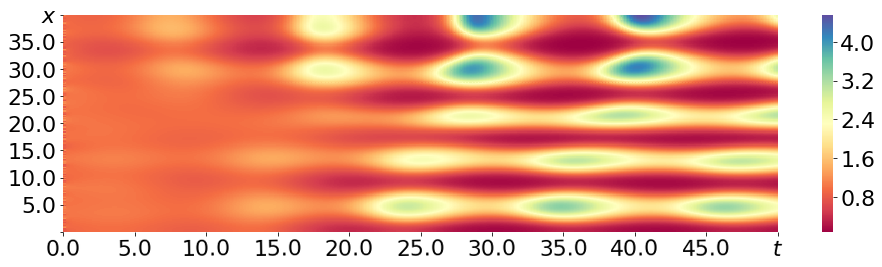

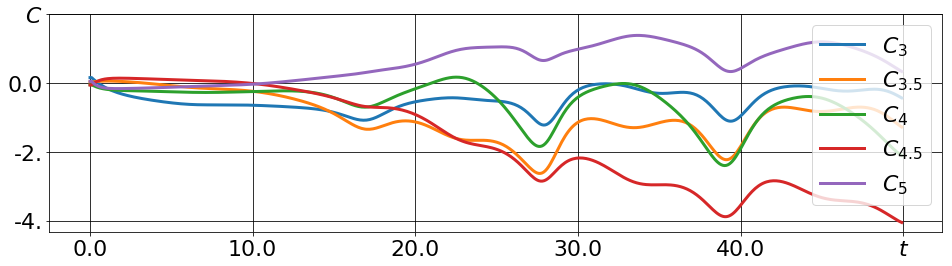

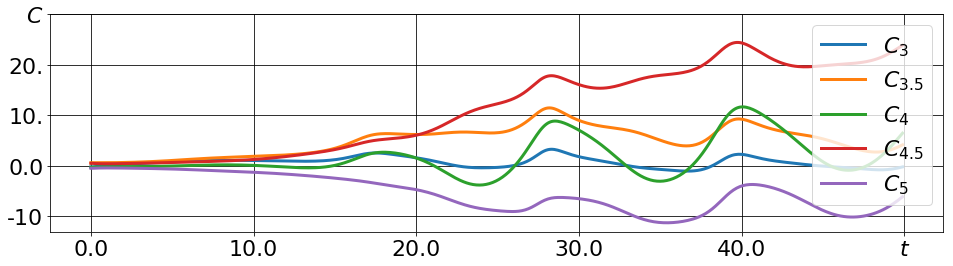

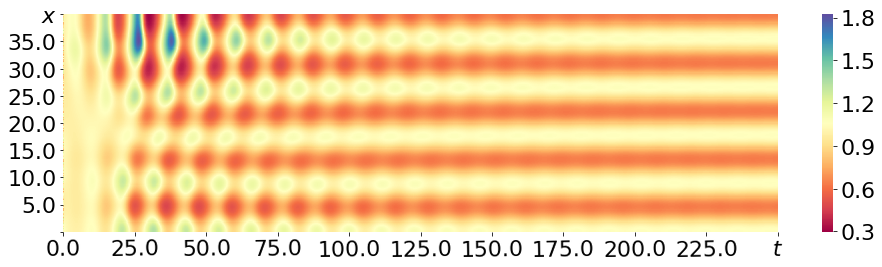

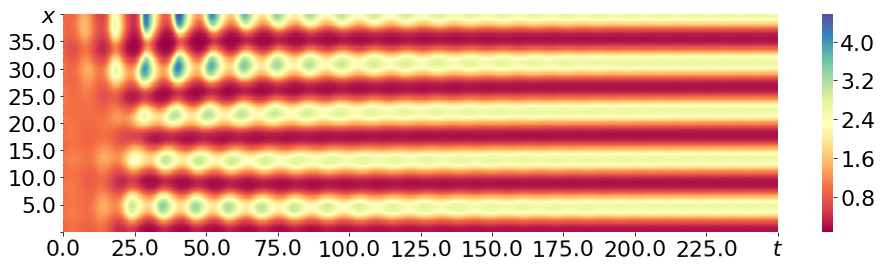

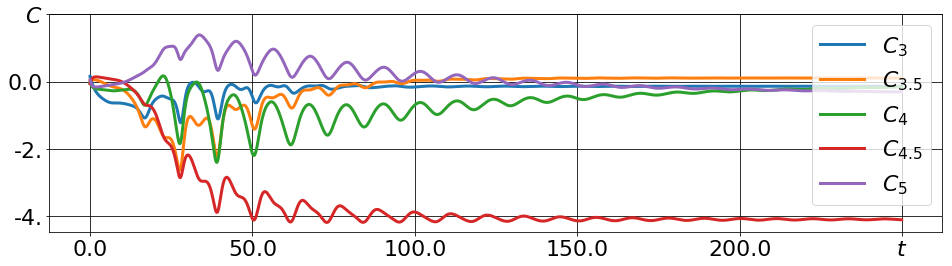

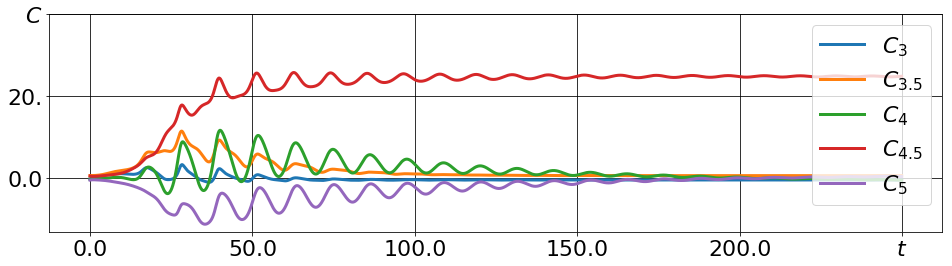

In [124]:
curr_7 = data_7.iloc[1]
print(curr_7)
ks = [3, 3.5, 4,4.5,5]
draw_heatmap(curr_7.folder, dt=0.1,dx=curr_7['dx'],x_max=10)
draw_fourier_coeffs(curr_7.folder,ks,0.2,10,0.1)
draw_heatmap(curr_7.folder,dt=0.1,dx=curr_7['dx'],x_max=50)
draw_fourier_coeffs(curr_7.folder,ks,0.2,50,0.1)
draw_heatmap(curr_7.folder, dt=0.1,dx=curr_7['dx'],x_max=250)
draw_fourier_coeffs(curr_7.folder,ks,0.2,250,0.1)

curr_7 = data_7.iloc[2]
print(curr_7)
ks = [3, 3.5, 4,4.5,5]
draw_heatmap(curr_7.folder, dt=0.1,dx=curr_7['dx'],x_max=10)
draw_fourier_coeffs(curr_7.folder,ks,0.2,10,0.1)
draw_heatmap(curr_7.folder,dt=0.1,dx=curr_7['dx'],x_max=50)
draw_fourier_coeffs(curr_7.folder,ks,0.2,50,0.1)
draw_heatmap(curr_7.folder, dt=0.1,dx=curr_7['dx'],x_max=250)
draw_fourier_coeffs(curr_7.folder,ks,0.2,250,0.1)

curr_7 = data_7.iloc[3]
print(curr_7)
ks = [3, 3.5, 4,4.5,5]
draw_heatmap(curr_7.folder, dt=0.1,dx=curr_7['dx'],x_max=10)
draw_fourier_coeffs(curr_7.folder,ks,0.2,10,0.1)
draw_heatmap(curr_7.folder,dt=0.1,dx=curr_7['dx'],x_max=50)
draw_fourier_coeffs(curr_7.folder,ks,0.2,50,0.1)
draw_heatmap(curr_7.folder, dt=0.1,dx=curr_7['dx'],x_max=250)
draw_fourier_coeffs(curr_7.folder,ks,0.2,250,0.1)